**Plan**

*   VGG, ResNet ...
*   데이터 증강
*   dropout, lr, batch size, batchnorm, epoch, shuffle ...
*   이미지 크롤링해서 추가??? <- 굳이





In [ ]:
# Drive Mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive')

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import time
import math
import pickle

## **데이터 불러오기**

In [ ]:
! unzip skku-2022-2-ml-second-project.zip

Archive:  skku-2022-2-ml-second-project.zip
  inflating: for-student/label-information.json  
  inflating: for-student/submission-example.csv  
  inflating: for-student/test/0.jpg  
  inflating: for-student/test/1.jpg  
  inflating: for-student/test/10.jpg  
  inflating: for-student/test/100.jpg  
  inflating: for-student/test/101.jpg  
  inflating: for-student/test/102.jpg  
  inflating: for-student/test/103.jpg  
  inflating: for-student/test/104.jpg  
  inflating: for-student/test/105.jpg  
  inflating: for-student/test/106.jpg  
  inflating: for-student/test/107.jpg  
  inflating: for-student/test/108.jpg  
  inflating: for-student/test/109.jpg  
  inflating: for-student/test/11.jpg  
  inflating: for-student/test/110.jpg  
  inflating: for-student/test/111.jpg  
  inflating: for-student/test/112.jpg  
  inflating: for-student/test/113.jpg  
  inflating: for-student/test/114.jpg  
  inflating: for-student/test/115.jpg  
  inflating: for-student/test/116.jpg  
  inflating: for-stude

In [ ]:
import json

with open('/content/drive/MyDrive/for-student/label-information.json', 'r') as f:
    json_data = json.load(f)
print(json.dumps(json_data) )

{"labels": ["downdog", "goddess", "mountain", "tree", "warrior1", "warrior2"], "mapping": {"downdog": 0, "goddess": 1, "mountain": 2, "tree": 3, "warrior1": 4, "warrior2": 5}}


In [ ]:
label_dict = {
    "downdog": 0,
    "goddess": 1,
    "mountain": 2,
    "tree": 3,
    "warrior1": 4,
    "warrior2": 5
}

label_list = []
img_list = []

for label_path in glob("./for-student/train/*"):
    for img_path in glob(label_path + "/*"):
        try:
          image = np.array(Image.open(img_path).convert("RGB").resize((224, 224)))
          img_list.append(image)
          label_list.append(label_dict[os.path.basename(label_path)]) # 라벨 추가하는 코드 만들기
        except:
          continue
label_list = np.array(label_list)
img_list = np.array(img_list)

In [ ]:
label_list.shape, img_list.shape

((2497,), (2497, 224, 224, 3))

In [ ]:
np.bincount(label_list)

array([381, 406, 453, 370, 432, 455])

In [ ]:
label_list

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_list, label_list, test_size=0.2, random_state=1003)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1997, 224, 224, 3), (500, 224, 224, 3), (1997,), (500,))

In [ ]:
np.bincount(y_test)

array([70, 99, 83, 64, 86, 98])

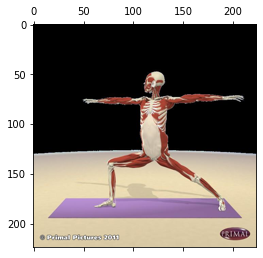

In [ ]:
import matplotlib.pyplot as plt

ex = img_list[2050]
plt.matshow(ex)

In [ ]:
print(label_list[2050])

5


## **데이터 증강**

In [ ]:
import numpy as np
import random
import tensorflow as tf

def augmentation(image):
  sat1 = np.random.randint(1, 5) #[1,5)
  sat2 = sat1
  while sat2 == sat1:
    sat2 = np.random.randint(1, 4)
  bri1 = random.uniform(0.05, 0.25)
  bri2 = random.uniform(0.05, 0.25)

  fl = tf.image.flip_left_right(image)
  c1 = tf.image.adjust_saturation(image, sat1)
  c2 = tf.image.adjust_saturation(image, sat2)
  b1 = tf.image.adjust_brightness(image, bri1)
  b2 = tf.image.adjust_brightness(image, bri2)

  return fl, c1, c2, b1, b2

In [ ]:
### 증강 6배 ###

aug_img = X_train
aug_label = y_train

for i, img in enumerate(X_train):
  fl, c1, c2, b1, b2 = augmentation(img)
  lab = y_train[i] #원본 데이터의 라벨

  aug_img = np.append(aug_img, tf.reshape(fl, [1,224,224,3]), axis=0)
  aug_img = np.append(aug_img, tf.reshape(c1, [1,224,224,3]), axis=0)
  aug_img = np.append(aug_img, tf.reshape(b1, [1,224,224,3]), axis=0)
  aug_img = np.append(aug_img, tf.reshape(c2, [1,224,224,3]), axis=0)
  aug_img = np.append(aug_img, tf.reshape(b2, [1,224,224,3]), axis=0)

  #label_list에 증강 데이터의 라벨 추가
  aug_label = np.append(aug_label, lab)
  aug_label = np.append(aug_label, lab)
  aug_label = np.append(aug_label, lab)
  aug_label = np.append(aug_label, lab)
  aug_label = np.append(aug_label, lab)

In [ ]:
#증강 후 데이터 개수 및 shape
aug_label.shape, aug_img.shape

((14982,), (14982, 224, 224, 3))

In [ ]:
np.bincount(label_list), np.bincount(aug_label)

(array([381, 406, 453, 370, 432, 455]),
 array([2286, 2436, 2718, 2220, 2592, 2730]))

In [ ]:
from sklearn.model_selection import train_test_split

x_augtr, x_augte, y_augtr, y_augte = train_test_split(aug_img, aug_label, test_size=0.2, random_state=1004)

In [ ]:
x_augtr.shape, x_augte.shape, y_augtr.shape, y_augte.shape

((11985, 224, 224, 3), (2997, 224, 224, 3), (11985,), (2997,))

In [ ]:
np.bincount(y_augte)

array([455, 503, 547, 423, 519, 550])

## **데이터 피클로 저장**

In [ ]:
import pickle

# 데이터 저장
#with open('img_list.pkl', 'wb') as f:
#    pickle.dump(img_list, f)

#with open('label_list.pkl', 'wb') as f:
#    pickle.dump(label_list, f)

#with open('aug_img.pkl', 'wb') as f:
#    pickle.dump(aug_img, f)

#with open('aug_label.pkl', 'wb') as f:
#    pickle.dump(aug_label, f)

with open('x_augtr.pkl', 'wb') as f:
    pickle.dump(x_augtr, f)

with open('y_augtr.pkl', 'wb') as f:
    pickle.dump(y_augtr, f)

with open('x_augte.pkl', 'wb') as f:
    pickle.dump(x_augte, f)

with open('y_augte.pkl', 'wb') as f:
    pickle.dump(y_augte, f)

In [ ]:
import pickle

# 데이터 로드
with open('x_augtr.pkl', 'rb') as f:
	x_augtr = pickle.load(f)
 
with open('y_augtr.pkl', 'rb') as f:
	y_augtr = pickle.load(f)

# with open('x_augte.pkl', 'rb') as f:
# 	x_augte = pickle.load(f)
 
# with open('y_augte.pkl', 'rb') as f:
# 	y_augte = pickle.load(f)

In [ ]:
label_list.shape, img_list.shape, aug_label.shape, aug_img.shape

In [ ]:
x_augtr.shape, x_augte.shape, y_augtr.shape, y_augte.shape

In [ ]:
x_augtr.shape,y_augtr.shape,

((11985, 224, 224, 3), (11985,))

In [ ]:
np.bincount(y_augtr)

array([1831, 1933, 2171, 1797, 2073, 2180])

## **데이터 마사징**

In [ ]:
# 라벨이 2 or 4인 것들의 인덱스 리스트에 모으기
# 인덱스 중 임의로 선택
# 해당 인덱스 삭제

two = np.where(y_augtr == 2)[0].tolist()
four = np.where(y_augtr == 4)[0].tolist()

deltwo = np.random.choice(two, math.ceil(len(two)*0.35)).tolist()
delfour = np.random.choice(four, math.ceil(len(four)*0.5)).tolist()

len(deltwo), len(delfour)

(760, 1037)

In [ ]:
deltwo.extend(delfour)
len(deltwo)

1797

In [ ]:
arr = np.ones((10,3,3,2))
np.delete(arr, [0, 3], axis=0).shape

(8, 3, 3, 2)

In [ ]:
x_augtr2 = np.delete(x_augtr, deltwo, axis=0)
y_augtr2 = np.delete(y_augtr, deltwo, axis=0)

In [ ]:
x_augtr2.shape, y_augtr2.shape

((10521, 224, 224, 3), (10521,))

In [ ]:
np.bincount(y_augtr2)

array([1831, 1933, 1519, 1797, 1261, 2180])

In [ ]:
with open('x_augtr2.pkl', 'wb') as f:
    pickle.dump(x_augtr2, f)

with open('y_augtr2.pkl', 'wb') as f:
    pickle.dump(y_augtr2, f)

In [ ]:
with open('x_augtr2.pkl', 'rb') as f:
	x_augtr2 = pickle.load(f)
 
with open('y_augtr2.pkl', 'rb') as f:
	y_augtr2 = pickle.load(f)

In [ ]:
x_augtr2.shape, y_augtr2.shape

((10521, 224, 224, 3), (10521,))

## **모델 불러오기**

#### VGG19

In [ ]:
vgg19 = tf.keras.applications.VGG19(include_top=False,
                                    weights="imagenet",
                                    input_shape=(224,224,3))

In [ ]:
for layer in vgg19.layers[:-5]:
    layer.trainable = False

In [ ]:
for layer in vgg19.layers:
    print(layer.name, layer.trainable)

input_5 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_conv4 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_conv4 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [ ]:
inp = vgg19.input
x = vgg19.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)

#x = tf.keras.layers.Dropout(rate=0.5)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
#x = tf.keras.layers.Dropout(rate=0.5)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
#x = tf.keras.layers.Dropout(rate=0.5)
x = tf.keras.layers.Dense(256, activation="relu")(x)
out = tf.keras.layers.Dense(6, activation="softmax")(x)

vgg = tf.keras.Model(inp, out)

In [ ]:
vgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#### ResNet50

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
resnet50 = tf.keras.applications.ResNet50(include_top=False,
                                    weights="imagenet",
                                    input_shape=(224,224,3))

In [ ]:
for layer in resnet50.layers[:-10]:
    layer.trainable = False

In [ ]:
for layer in resnet50.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [ ]:
inp = resnet50.input
x = resnet50.output

x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
out = tf.keras.layers.Dense(6, activation="softmax")(x)

rn50 = tf.keras.Model(inp, out)

In [ ]:
rn50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

#### ResNet101

In [ ]:
resnet101 = tf.keras.applications.ResNet101(include_top=False,
                                    weights="imagenet",
                                    input_shape=(224,224,3))

In [ ]:
for layer in resnet101.layers[:-10]:
    layer.trainable = False

In [ ]:
for layer in resnet101.layers:
    print(layer.name, layer.trainable)

input_3 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [ ]:
inp = resnet101.input
x = resnet101.output

x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
out = tf.keras.layers.Dense(6, activation="softmax")(x)

rn101 = tf.keras.Model(inp, out)

In [ ]:
rn101.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## **모델 학습**

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
sce_loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
rn50.compile(
    optimizer = adam,
    loss = sce_loss,
    metrics=["acc"]
)

In [ ]:
rn50.fit(
    x_augtr2, y_augtr2,
    epochs=6,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/6
263/263 [==============================] - 43s 148ms/step - loss: 0.1937 - acc: 0.9376 - val_loss: 0.2772 - val_acc: 0.9311
Epoch 2/6
263/263 [==============================] - 38s 144ms/step - loss: 0.0749 - acc: 0.9758 - val_loss: 0.0499 - val_acc: 0.9824
Epoch 3/6
263/263 [==============================] - 38s 143ms/step - loss: 0.0471 - acc: 0.9850 - val_loss: 0.0476 - val_acc: 0.9834
Epoch 4/6
263/263 [==============================] - 38s 144ms/step - loss: 0.0454 - acc: 0.9853 - val_loss: 0.0593 - val_acc: 0.9829
Epoch 5/6
 14/263 [>.............................] - ETA: 29s - loss: 0.0276 - acc: 0.9911

KeyboardInterrupt: ignored

In [ ]:
pred = rn50.predict(x_augte)
pred.shape # (batch, num_class)

94/94 [==============================] - 17s 167ms/step


(2997, 6)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(pred, axis=1), y_augte))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       455
           1       0.99      0.99      0.99       502
           2       1.00      0.99      1.00       550
           3       1.00      1.00      1.00       421
           4       0.97      0.95      0.96       529
           5       0.95      0.97      0.96       540

    accuracy                           0.98      2997
   macro avg       0.98      0.98      0.98      2997
weighted avg       0.98      0.98      0.98      2997



## 최종 예측 & submission

In [ ]:
testset = []

for img_path in glob("./for-student/test/*"):
        try:
          image = np.array(Image.open(img_path).convert("RGB").resize((224, 224)))
          testset.append(image)
        except:
          continue
testset = np.array(testset)

In [ ]:
testset.shape

(389, 224, 224, 3)

In [ ]:
file_list = os.listdir('./for-student/test/')
#file_list

In [ ]:
num = []
for f in file_list:
  n = int(f[:-4])
  num.append(n)

In [ ]:
### 최종 예측 ###
sub = rn50.predict(testset)
sub = np.argmax(sub, axis=1)
sub.shape # (batch, num_class)

13/13 [==============================] - 2s 95ms/step


(389,)

In [ ]:
preddf = pd.DataFrame({'Id' : file_list,
                       'Category': sub,
                       'num': num})
preddf = preddf.sort_values('num', axis=0, ascending=True)
preddf.drop(['num'], axis=1, inplace=True)
preddf['Category'].value_counts()

5    100
0     96
1     76
3     67
2     29
4     21
Name: Category, dtype: int64

In [ ]:
preddf.to_csv('1201_3_batch64.csv', index = None)